**Легенда**

Мы - онлайн магазин спортивных товаров: одежды, обуви, аксессуаров и спорт-питания. На главной странице магазина мы показываем пользователям баннеры с целью стимулирования своих продаж. Сейчас там случайно показывается один из 5 баннеров. Каждый баннер рекламирует конкретный продукт или всю компанию.
Наши маркетологи считают, что:

опыт взаимодействия с баннерами может различаться по сегментам, а их эффективность – зависеть от особенностей пользовательского поведения.

У менеджера компании появилось предложение от партнеров продать это место для баннера и рекламировать там другой сервис (оплата предполагается по CPC-модели, т.е. стоимость за клик).

**Задача**

Помогите менеджеру принять решение – нужно ли продавать это место для рекламы другого сервиса.

**План действий**
#### 1) Проводим EDA  (Exploratory Data Analysis)

#### 2) Рассчитаем CTR % (кликабельность объявлений) и CR % (коэффициент конверсии в заказы)
Это нужно, чтобы PM мог понять какой потенциально будет "выхлоп" при CPC модели в целом, не исключено, что баннеры несут толко имиджевую составляющую и имеют низкий клик рейт. 

Так же необходимо рассмотреть CTR и CR в различных сегментах и определить наиболее успешные с точки зрения конверсий.

In [ ]:
pip install pingouin

In [146]:
import pandas as pd
import seaborn as sns
import numpy as np
import pingouin as pg
import matplotlib.pyplot as plt

In [127]:
df = pd.read_csv('C:/Users/hazar/Downloads/ha_data/ha_data.csv', sep = ';', parse_dates = ['time'])

#### 1) Проводим EDA  (Exploratory Data Analysis)

In [128]:
df.shape

(8471226, 7)

In [129]:
df.dtypes

order_id               float64
page_id                float64
product                 object
site_version            object
time            datetime64[ns]
title                   object
user                    object
dtype: object

In [131]:
df.head(5)

,order_id,page_id,product,site_version,time,title,user
0,NaN,3.0,company,mobile,2017-02-09 20:24:04,banner_show,user_0
1,NaN,3699687.0,company,mobile,2017-02-07 10:03:07,banner_show,user_0
2,NaN,14.0,sneakers,mobile,2017-01-29 13:02:23,banner_show,user_1
3,NaN,10362176.0,company,mobile,2017-04-12 15:39:19,banner_show,user_1
4,NaN,14.0,sneakers,mobile,2017-01-29 13:04:42,banner_click,user_1


In [135]:
# Помним, что в условиях предусмотрено наличие NA
# order_id - уникальный номер покупки (NA для кликов и показов баннера)
# page_id - уникальный номер страницы для связки событий (NA для покупок)

df.isnull().sum()

order_id        8222504
page_id          248722
product               0
site_version          0
time                  0
title                 0
user                  0
date                  0
dtype: int64

In [136]:
# Добавляем поле с датой
df['date'] = df.time.dt.date

In [166]:
df.head(5)

,order_id,page_id,product,site_version,time,title,user,date
0,NaN,3.0,company,mobile,2017-02-09 20:24:04,banner_show,user_0,2017-02-09
1,NaN,3699687.0,company,mobile,2017-02-07 10:03:07,banner_show,user_0,2017-02-07
2,NaN,14.0,sneakers,mobile,2017-01-29 13:02:23,banner_show,user_1,2017-01-29
3,NaN,10362176.0,company,mobile,2017-04-12 15:39:19,banner_show,user_1,2017-04-12
4,NaN,14.0,sneakers,mobile,2017-01-29 13:04:42,banner_click,user_1,2017-01-29


Посмотрим на структуру и содержание полей детальнее:

In [165]:
df['product'].value_counts()

clothes             1786438
company             1725059
sneakers            1703345
sports_nutrition    1634625
accessories         1621759
Name: product, dtype: int64

In [159]:
df['product'].value_counts(normalize = True)

clothes             0.210883
company             0.203637
sneakers            0.201074
sports_nutrition    0.192962
accessories         0.191443
Name: product, dtype: float64

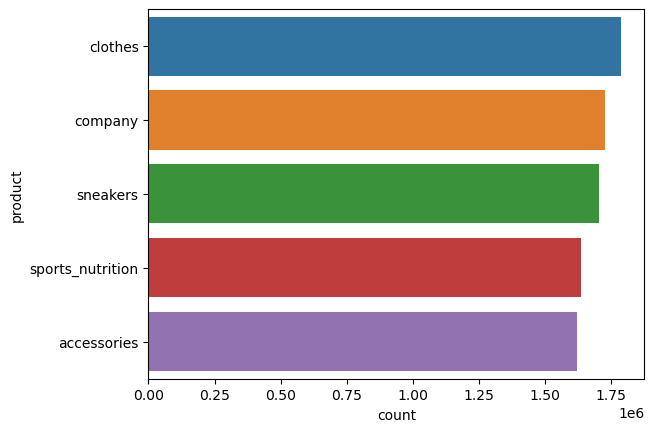

In [148]:
sns.countplot(data = df, y = 'product', order=df['product'].value_counts().index )

In [93]:
df['title'].value_counts(normalize=True)

banner_show     0.872757
banner_click    0.097883
order           0.029361
Name: title, dtype: float64

In [184]:
df.groupby('title').agg({'user': ['count', 'nunique']})

user         
                count  nunique
title                         
banner_click   829185   742459
banner_show   7393319  4254621
order          248722   237866

Видим, что на каждого уникального пользователя может приходиться несколько строк

In [180]:
# отберем пример купившего
df.query("title == 'order'").head(5)

,order_id,page_id,product,site_version,time,title,user,date,bought_flag
66,504623.0,NaN,sports_nutrition,desktop,2017-03-03 10:15:41,order,user_21,2017-03-03,1
112,463510.0,NaN,sneakers,desktop,2017-02-08 21:16:48,order,user_35,2017-02-08,1
113,506727.0,NaN,clothes,desktop,2017-02-10 19:12:07,order,user_35,2017-02-10,1
171,95866.0,NaN,sports_nutrition,mobile,2017-02-06 10:32:36,order,user_53,2017-02-06,1
185,575369.0,NaN,accessories,mobile,2017-02-10 19:18:02,order,user_55,2017-02-10,1


In [ ]:
66	504623.0	NaN	sports_nutrition	desktop	2017-03-03 10:15:41	order	user_21	2017-03-03

In [181]:
# посмотрим как выглядят все виды возможных событий на примере 1 купившего пользователя
df.query("user == 'user_21'").sort_values('date')

,order_id,page_id,product,site_version,time,title,user,date,bought_flag
60,NaN,93.0,sports_nutrition,desktop,2017-01-11 17:14:04,banner_show,user_21,2017-01-11,1
61,NaN,6153399.0,clothes,desktop,2017-01-12 08:41:38,banner_show,user_21,2017-01-12,1
63,NaN,17137473.0,company,desktop,2017-02-28 11:31:01,banner_show,user_21,2017-02-28,1
65,NaN,17137473.0,company,desktop,2017-02-28 11:32:49,banner_click,user_21,2017-02-28,1
66,504623.0,NaN,sports_nutrition,desktop,2017-03-03 10:15:41,order,user_21,2017-03-03,1
64,NaN,18850043.0,sports_nutrition,desktop,2017-04-07 04:39:00,banner_show,user_21,2017-04-07,1
62,NaN,15907953.0,company,desktop,2017-04-26 07:25:52,banner_show,user_21,2017-04-26,1


####  1) Рассчитаем  CTR % (кликабельность объявлений) и CR % (коэффициент конверсии в заказы)
Это нужно, чтобы PM мог понять какой потенциально будет "выхлоп" при CPC модели в целом, не исключено, что баннеры несут толко имиджевую составляющую и имеют низкий клик рейт. 

Так же необходимо рассмотреть CTR и CR в различных сегментах и определить наиболее успешные и проседающие
с точки зрения конверсий.

In [185]:
df.groupby('title').agg({'user': ['count', 'nunique']})

user         
                count  nunique
title                         
banner_click   829185   742459
banner_show   7393319  4254621
order          248722   237866

In [183]:
df.head()

,order_id,page_id,product,site_version,time,title,user,date,bought_flag
0,NaN,3.0,company,mobile,2017-02-09 20:24:04,banner_show,user_0,2017-02-09,0
1,NaN,3699687.0,company,mobile,2017-02-07 10:03:07,banner_show,user_0,2017-02-07,0
2,NaN,14.0,sneakers,mobile,2017-01-29 13:02:23,banner_show,user_1,2017-01-29,0
3,NaN,10362176.0,company,mobile,2017-04-12 15:39:19,banner_show,user_1,2017-04-12,0
4,NaN,14.0,sneakers,mobile,2017-01-29 13:04:42,banner_click,user_1,2017-01-29,0


In [265]:
df_user_count_date = df.groupby(['title', 'date'], as_index = False).agg({'user': 'nunique'})
df_user_count_date

,title,date,user
0,banner_click,2017-01-01,3341
1,banner_click,2017-01-02,3530
2,banner_click,2017-01-03,3790
3,banner_click,2017-01-04,4039
4,banner_click,2017-01-05,4248
...,...,...,...
448,order,2017-05-27,1259
449,order,2017-05-28,1281
450,order,2017-05-29,1256
451,order,2017-05-30,1189


In [266]:
pivot_date = df_user_count_date.pivot(index = 'date', columns = 'title', values = 'user').reset_index()
pivot_date

title,date,banner_click,banner_show,order
0,2017-01-01,3341,28069,777
1,2017-01-02,3530,30338,750
2,2017-01-03,3790,32554,811
3,2017-01-04,4039,34551,852
4,2017-01-05,4248,36404,863
...,...,...,...,...
146,2017-05-27,5297,45650,1259
147,2017-05-28,5005,42375,1281
148,2017-05-29,4592,39922,1256
149,2017-05-30,4257,36449,1189


In [267]:
# Рассчитаем  CTR % (кликабельность объявлений) и CR % (коэффициент конверсии в заказы)
pivot_date = pivot_date.assign(CTR = (pivot_date.banner_click/pivot_date.banner_show), \
                           CR = (pivot_date.order/pivot_date.banner_show)
                          )
pivot_date

title,date,banner_click,banner_show,order,CTR,CR
0,2017-01-01,3341,28069,777,0.119028,0.027682
1,2017-01-02,3530,30338,750,0.116356,0.024721
2,2017-01-03,3790,32554,811,0.116422,0.024912
3,2017-01-04,4039,34551,852,0.116900,0.024659
4,2017-01-05,4248,36404,863,0.116690,0.023706
...,...,...,...,...,...,...
146,2017-05-27,5297,45650,1259,0.116035,0.027579
147,2017-05-28,5005,42375,1281,0.118112,0.030230
148,2017-05-29,4592,39922,1256,0.115024,0.031461
149,2017-05-30,4257,36449,1189,0.116793,0.032621


C:\Users\hazar\AppData\Local\Temp\ipykernel_14860\1914424833.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:.0%}'.format(n) for n in ax.get_yticks()])


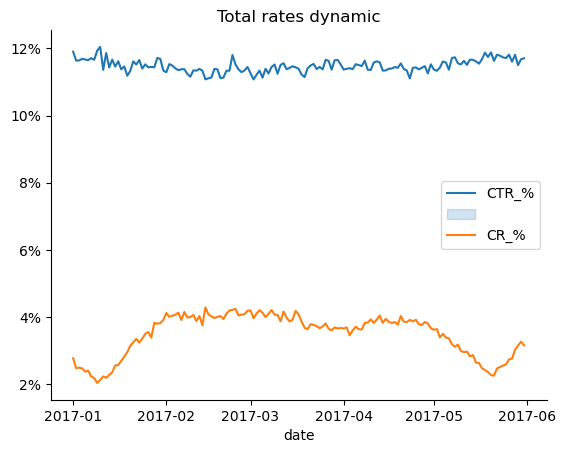

In [268]:
ax= sns.lineplot(data = pivot_date, x = 'date', y ='CTR' )
ax2=sns.lineplot(data = pivot_date, x = 'date', y ='CR' )
ax.legend(['CTR_%','', 'CR_%'])
ax.set(ylabel=None)
ax.set_title('Total rates dynamic')
ax.set_yticklabels(['{:.0%}'.format(n) for n in ax.get_yticks()])
sns.despine()

#### В целом видно, что CTR находится выше среднего уровня по сравнению с рыночным бенчмарком
#### CR пережил два спада, и в последнее время корректируется. С февраля по май CR находился на среднерыночном уровне.
https://www.wordstream.com/blog/ws/2023/05/15/google-ads-benchmarks 

Для сравнения можно взять категории:
##### Shopping, Collectibles & Gifts (CTR: 6.39%, CR: 3.69%)
##### Sports & Recreation (CTR: 10.53%, CR: 5.69%)
(сделать скидку на то, что данные в задаче не самые актуальные)

In [313]:
df_user_count_product = df.groupby(['title', 'product'], as_index = False).agg({'user': 'nunique'})
pivot_product = df_user_count_product.pivot(index = 'product', columns = 'title', values = 'user').reset_index()
pivot_product = pivot_product.assign(CTR_percent = (pivot_product.banner_click/pivot_product.banner_show) *100, \
                           CR_percent = (pivot_product.order/pivot_product.banner_show)*100
                          )
pivot_product.sort_values(['CTR_percent', 'CR_percent'], ascending = False)

title,product,banner_click,banner_show,order,CTR_percent,CR_percent
1,clothes,210109.0,1164914.0,110347.0,18.036439,9.472545
3,sneakers,174802.0,1163808.0,66917.0,15.019831,5.749832
4,sports_nutrition,139854.0,1173163.0,23609.0,11.921106,2.012423
0,accessories,131998.0,1155775.0,44160.0,11.420735,3.820813
2,company,140683.0,1256721.0,NaN,11.194450,NaN


#### - Баннеры категории "company" не конвертируются в заказы - необходимо доп. исследование несут ли такие баннеры имиджевую ценность.
#### - Возможно от company стоит отказаться в пользу показа баннеров продуктов или обсудить опцию продажи показов баннеров партнёров в этом слоте.
#### - На первом месте по CTR и CR находятся баннеры из категории "clothes" 18% и 9,5% соответственно
#### - Самый низкий CR  у "sports_nutrition" 2%

In [315]:
df_user_count_site_version = df.groupby(['title', 'site_version'], as_index = False).agg({'user': 'nunique'})
pivot_site_version = df_user_count_site_version.pivot(index = 'site_version', columns = 'title', values = 'user').reset_index()
pivot_site_version = pivot_site_version.assign(CTR_percent = (pivot_site_version.banner_click/pivot_site_version.banner_show) *100, \
                           CR_percent = (pivot_site_version.order/pivot_site_version.banner_show)*100
                          )
pivot_site_version.sort_values(['CTR_percent', 'CR_percent'])

title,site_version,banner_click,banner_show,order,CTR_percent,CR_percent
0,desktop,111334,1424772,125404,7.814163,8.801689
1,mobile,631645,2857189,112574,22.107218,3.940026


#### Здесь важно обратить внимание PM-а, что в десктопной версии CTR в 3 раза ниже, чем в мобильной, при этом конверсия в заказ в 2 раза выше

In [314]:
df_user_count_site_version_date = df.groupby(['title', 'date', 'site_version'], as_index = False).agg({'user': 'nunique'})

pivot_site_version_date = df_user_count_site_version.pivot(index = ['site_version', 'date'], columns = 'title', values = 'user').reset_index()
pivot_site_version_date
pivot_site_version_date = pivot_site_version_date.assign(CTR = (pivot_site_version_date.banner_click/pivot_site_version_date.banner_show), \
                           CR = (pivot_site_version_date.order/pivot_site_version_date.banner_show)
                          )
pivot_site_version_date

title,site_version,date,banner_click,banner_show,order,CTR,CR
0,desktop,2017-01-01,416,7606,410,0.054694,0.053905
1,desktop,2017-01-02,453,8433,408,0.053718,0.048381
2,desktop,2017-01-03,489,8889,375,0.055012,0.042187
3,desktop,2017-01-04,515,9616,445,0.053557,0.046277
4,desktop,2017-01-05,560,10273,447,0.054512,0.043512
...,...,...,...,...,...,...,...
297,mobile,2017-05-27,4614,33452,567,0.137929,0.016950
298,mobile,2017-05-28,4437,31234,630,0.142057,0.020170
299,mobile,2017-05-29,4002,29350,588,0.136354,0.020034
300,mobile,2017-05-30,3742,27016,570,0.138511,0.021099


C:\Users\hazar\AppData\Local\Temp\ipykernel_14860\330036533.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:.0%}'.format(n) for n in ax.get_yticks()])


Text(0.5, 1.0, 'CTR by platform')

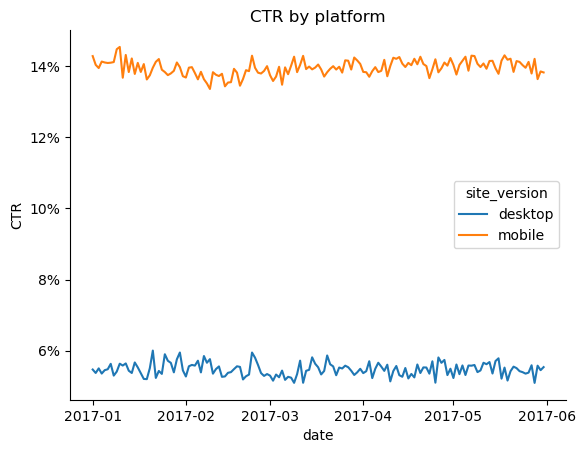

In [310]:
CTR_site_version_graph = pivot_site_version_date.groupby(['date', 'site_version']).agg({'CTR': 'mean'})
CTR_site_version_graph
ax= sns.lineplot(data = CTR_site_version_graph, x = 'date', y ='CTR', hue = 'site_version' )
ax.set_yticklabels(['{:.0%}'.format(n) for n in ax.get_yticks()])
sns.despine()
ax.set_title('CTR by platform')

C:\Users\hazar\AppData\Local\Temp\ipykernel_14860\3463094493.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:.0%}'.format(n) for n in ax.get_yticks()])


Text(0.5, 1.0, 'CR by platform')

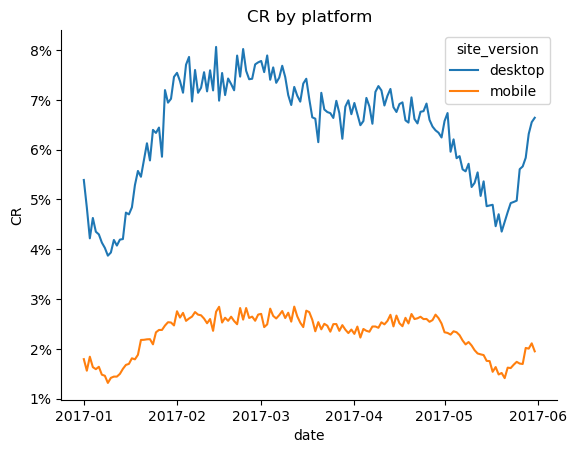

In [311]:
CR_site_version_graph = pivot_site_version_date.groupby(['date', 'site_version']).agg({'CR': 'mean'})
CR_site_version_graph
ax= sns.lineplot(data = CR_site_version_graph, x = 'date', y ='CR', hue = 'site_version' )
ax.set_yticklabels(['{:.0%}'.format(n) for n in ax.get_yticks()])
sns.despine()
ax.set_title('CR by platform')

### Summary:

Для принятия взвешенного решения продать место для баннера или использовать самим нужно больше данных, как минимум - цена за клик от пратнёров и данные по сумме наших продаж с конверсий от этих баннеров сейчас.

Но, основываясь на имеющихся данных, в целом видно, что баннеры работают неплохо, CTR находится выше среднего уровня по сравнению с рыночным бенчмарком.
CR пережил два спада, и в последнее время корректируется. С февраля по май CR находился на среднерыночном уровне.
Benchmarks:  https://www.wordstream.com/blog/ws/2023/05/15/google-ads-benchmarks 

Баннеры категории "company" не конвертируются в заказы - необходимо доп. исследование, несут ли такие баннеры имиджевую ценность для компани.
Возможно от "company" стоит отказаться в пользу показа баннеров продуктов или обсудить опцию продажи показов баннеров партнёров в этом слоте.

На первом месте по CTR и CR находятся баннеры из категории "clothes" 18% и 9,5% соответственно - можно поисследовать чем они привлекательны для клиентов и попробовать применить практику на менее успешных направлениях.

Самый низкий CR  у "sports_nutrition" 2% - изучить вопрос и, возможно, отказаться в пользу других показов или категорий товаров.


### P.S. Если бы в стояла задача оценить конверсию из баннеров проведя АБ-тест, сравнивая два вида показов, можно было провести подобное исследование:
Есть ли стат. значимая взаимосвязь между покупками пользователей, и показанными им баннерами
Возможно разные баннеры вызывают разную конверсию в покупку в качестве контрольной группы можно взять тех, кому показали ТОЛЬКО баннер компании (как относительно нейтральный с т.з. призыва к действию), а в качестве целевой - кому любые КРОМЕ баннера компании (т.е. конкретный товар).
#### Но т.к. из баннеров company нулевая конверсия это исследование не имеет смысла, просто решил не удалять :-)


Поскольку по каждому пользователю может быть несколько строк, для дальнейшего удобства добавим сквозной признак совершения заказа на все строки конкретного user-а 

In [316]:
# Выделим список с юзерами, совершившими покупку, чтобы на их основе сделать признак купившего
# Делаем временное поле, для отбора списка юзеров, совершивших покупку 
df['bought_flag_temp'] = (df['title'] == 'order').astype(int)
df_bought_users = df.query("bought_flag_temp == 1")

In [317]:
df_bought_users.head()

,order_id,page_id,product,site_version,time,title,user,date,bought_flag,bought_flag_temp
66,504623.0,NaN,sports_nutrition,desktop,2017-03-03 10:15:41,order,user_21,2017-03-03,1,1
112,463510.0,NaN,sneakers,desktop,2017-02-08 21:16:48,order,user_35,2017-02-08,1,1
113,506727.0,NaN,clothes,desktop,2017-02-10 19:12:07,order,user_35,2017-02-10,1,1
171,95866.0,NaN,sports_nutrition,mobile,2017-02-06 10:32:36,order,user_53,2017-02-06,1,1
185,575369.0,NaN,accessories,mobile,2017-02-10 19:18:02,order,user_55,2017-02-10,1,1


In [318]:
df_bought_users.user.nunique()       

237866

In [319]:
# Добавляем поле с признаком
df['bought_flag'] = df['user'].isin(df_bought_users['user']).astype(int)

In [320]:
# check что лишних не образовалось
df.query("bought_flag == 1").user.nunique()   

237866

In [321]:
# удаляем temp флаг
df = df.drop('bought_flag_temp', axis = 1)

In [322]:
df.head()

,order_id,page_id,product,site_version,time,title,user,date,bought_flag
0,NaN,3.0,company,mobile,2017-02-09 20:24:04,banner_show,user_0,2017-02-09,0
1,NaN,3699687.0,company,mobile,2017-02-07 10:03:07,banner_show,user_0,2017-02-07,0
2,NaN,14.0,sneakers,mobile,2017-01-29 13:02:23,banner_show,user_1,2017-01-29,0
3,NaN,10362176.0,company,mobile,2017-04-12 15:39:19,banner_show,user_1,2017-04-12,0
4,NaN,14.0,sneakers,mobile,2017-01-29 13:04:42,banner_click,user_1,2017-01-29,0


Через RN  выбрать пользователей  у которых RN 1 максимальный, т.е. посмотрели только один банер.

In [323]:
# Ошибка возникает из-за дубликатов в некоторых строках (например page_id 17137473 дважды)
df_user_21['RN'] = df_user_21\
.groupby('user', dropna=False)\
.cumcount()+1\

df_user_21

C:\Users\hazar\AppData\Local\Temp\ipykernel_14860\3339231775.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_user_21['RN'] = df_user_21\


,order_id,page_id,product,site_version,time,title,user,date,bought_flag,RN
60,NaN,93.0,sports_nutrition,desktop,2017-01-11 17:14:04,banner_show,user_21,2017-01-11,1,1
61,NaN,6153399.0,clothes,desktop,2017-01-12 08:41:38,banner_show,user_21,2017-01-12,1,2
62,NaN,15907953.0,company,desktop,2017-04-26 07:25:52,banner_show,user_21,2017-04-26,1,3
63,NaN,17137473.0,company,desktop,2017-02-28 11:31:01,banner_show,user_21,2017-02-28,1,4
64,NaN,18850043.0,sports_nutrition,desktop,2017-04-07 04:39:00,banner_show,user_21,2017-04-07,1,5
65,NaN,17137473.0,company,desktop,2017-02-28 11:32:49,banner_click,user_21,2017-02-28,1,6
66,504623.0,NaN,sports_nutrition,desktop,2017-03-03 10:15:41,order,user_21,2017-03-03,1,7


In [324]:
# Оставим banner_show, чтобы ранжировать только показы, а не все виды активности(без кликов или покупок)
# Готовим тиблицу для отбора пользователей с единичными показами
# Alarm возникает из-за дубликатов в некоторых строках, но это нам не помешает т.к. нужны как раз юзеры с 1 показом

df_show_only = df.query("title == 'banner_show'")

df_show_only['RN'] = df_show_only\
    .groupby('user')\
    .cumcount()+1

C:\Users\hazar\AppData\Local\Temp\ipykernel_14860\3719438287.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_show_only['RN'] = df_show_only\


In [26]:
df_show_only.head(5)

,order_id,page_id,product,site_version,time,title,user,date,bought_flag,RN
0,NaN,3.0,company,mobile,2017-02-09 20:24:04,banner_show,user_0,2017-02-09,0,1
1,NaN,3699687.0,company,mobile,2017-02-07 10:03:07,banner_show,user_0,2017-02-07,0,2
2,NaN,14.0,sneakers,mobile,2017-01-29 13:02:23,banner_show,user_1,2017-01-29,0,1
3,NaN,10362176.0,company,mobile,2017-04-12 15:39:19,banner_show,user_1,2017-04-12,0,2
5,NaN,18.0,sneakers,desktop,2017-01-11 09:22:12,banner_show,user_2,2017-01-11,0,1


In [325]:
df.user.isna().sum()

0

In [326]:
df_max_rn = df_show_only\
    .groupby('user', as_index = False)\
    .agg(rows_qty = ('RN', 'max'))
df_max_rn

,user,rows_qty
0,user_0,2
1,user_1,2
2,user_10,3
3,user_100,1
4,user_1000,1
...,...,...
4254616,user_999995,1
4254617,user_999996,7
4254618,user_999997,1
4254619,user_999998,1


In [327]:
# Теперь можно выбрать пользователей, у которых был только 1 показ
one_banner_shown = df_max_rn\
    .query("rows_qty == 1")
one_banner_shown

,user,rows_qty
3,user_100,1
4,user_1000,1
6,user_100000,1
7,user_1000000,1
9,user_1000002,1
...,...,...
4254612,user_999991,1
4254614,user_999993,1
4254616,user_999995,1
4254618,user_999997,1


В исходном df было 8 471 226 rows, в таблице с единственным показом баннера 2 625 270 rows - можно  смело использовать 
one_banner_shown для отбора user для групп тестирования.

In [328]:
df.head(5)

,order_id,page_id,product,site_version,time,title,user,date,bought_flag
0,NaN,3.0,company,mobile,2017-02-09 20:24:04,banner_show,user_0,2017-02-09,0
1,NaN,3699687.0,company,mobile,2017-02-07 10:03:07,banner_show,user_0,2017-02-07,0
2,NaN,14.0,sneakers,mobile,2017-01-29 13:02:23,banner_show,user_1,2017-01-29,0
3,NaN,10362176.0,company,mobile,2017-04-12 15:39:19,banner_show,user_1,2017-04-12,0
4,NaN,14.0,sneakers,mobile,2017-01-29 13:04:42,banner_click,user_1,2017-01-29,0


In [36]:
df['one_shown_flag'] = df.user.isin(one_banner_shown.user).astype(int)

In [43]:
df.head(5)

,order_id,page_id,product,site_version,time,title,user,date,bought_flag,one_shown_flag
0,NaN,3.0,company,mobile,2017-02-09 20:24:04,banner_show,user_0,2017-02-09,0,0
1,NaN,3699687.0,company,mobile,2017-02-07 10:03:07,banner_show,user_0,2017-02-07,0,0
2,NaN,14.0,sneakers,mobile,2017-01-29 13:02:23,banner_show,user_1,2017-01-29,0,0
3,NaN,10362176.0,company,mobile,2017-04-12 15:39:19,banner_show,user_1,2017-04-12,0,0
4,NaN,14.0,sneakers,mobile,2017-01-29 13:04:42,banner_click,user_1,2017-01-29,0,0


In [42]:
df.one_shown_flag.sum()

2996271

In [ ]:
df.

In [39]:
df_user_21

,order_id,page_id,product,site_version,time,title,user,date,bought_flag,RN
60,NaN,93.0,sports_nutrition,desktop,2017-01-11 17:14:04,banner_show,user_21,2017-01-11,1,1
61,NaN,6153399.0,clothes,desktop,2017-01-12 08:41:38,banner_show,user_21,2017-01-12,1,2
62,NaN,15907953.0,company,desktop,2017-04-26 07:25:52,banner_show,user_21,2017-04-26,1,3
63,NaN,17137473.0,company,desktop,2017-02-28 11:31:01,banner_show,user_21,2017-02-28,1,4
64,NaN,18850043.0,sports_nutrition,desktop,2017-04-07 04:39:00,banner_show,user_21,2017-04-07,1,5
65,NaN,17137473.0,company,desktop,2017-02-28 11:32:49,banner_click,user_21,2017-02-28,1,6
66,504623.0,NaN,sports_nutrition,desktop,2017-03-03 10:15:41,order,user_21,2017-03-03,1,7


In [329]:
df['company_banner_flag'] = (df['product'] == 'company').astype(int)

In [ ]:
# df['company_banner_flag'] = np.where(df['product'] == 'company', 1, 0)

In [45]:
df.head(5)

,order_id,page_id,product,site_version,time,title,user,date,bought_flag,one_shown_flag,company_banner_flag
0,NaN,3.0,company,mobile,2017-02-09 20:24:04,banner_show,user_0,2017-02-09,0,0,1
1,NaN,3699687.0,company,mobile,2017-02-07 10:03:07,banner_show,user_0,2017-02-07,0,0,1
2,NaN,14.0,sneakers,mobile,2017-01-29 13:02:23,banner_show,user_1,2017-01-29,0,0,0
3,NaN,10362176.0,company,mobile,2017-04-12 15:39:19,banner_show,user_1,2017-04-12,0,0,1
4,NaN,14.0,sneakers,mobile,2017-01-29 13:04:42,banner_click,user_1,2017-01-29,0,0,0


In [331]:
df_1_banner.head(5)

,order_id,page_id,product,site_version,time,title,user,date,bought_flag,one_shown_flag,company_banner_flag
5,NaN,18.0,sneakers,desktop,2017-01-11 09:22:12,banner_show,user_2,2017-01-11,0,1,0
6,NaN,18.0,sneakers,desktop,2017-01-11 09:24:43,banner_click,user_2,2017-01-11,0,1,0
11,NaN,33.0,sports_nutrition,mobile,2017-01-14 05:33:39,banner_show,user_4,2017-01-14,0,1,0
12,NaN,34.0,sneakers,mobile,2017-03-02 15:10:16,banner_show,user_5,2017-03-02,0,1,0
13,NaN,35.0,sneakers,desktop,2017-02-10 12:19:30,banner_show,user_6,2017-02-10,0,1,0


In [332]:
df.query("user == 'user_21'")

,order_id,page_id,product,site_version,time,title,user,date,bought_flag,company_banner_flag
60,NaN,93.0,sports_nutrition,desktop,2017-01-11 17:14:04,banner_show,user_21,2017-01-11,1,0
61,NaN,6153399.0,clothes,desktop,2017-01-12 08:41:38,banner_show,user_21,2017-01-12,1,0
62,NaN,15907953.0,company,desktop,2017-04-26 07:25:52,banner_show,user_21,2017-04-26,1,1
63,NaN,17137473.0,company,desktop,2017-02-28 11:31:01,banner_show,user_21,2017-02-28,1,1
64,NaN,18850043.0,sports_nutrition,desktop,2017-04-07 04:39:00,banner_show,user_21,2017-04-07,1,0
65,NaN,17137473.0,company,desktop,2017-02-28 11:32:49,banner_click,user_21,2017-02-28,1,1
66,504623.0,NaN,sports_nutrition,desktop,2017-03-03 10:15:41,order,user_21,2017-03-03,1,0


In [ ]:
Проверим 

In [333]:
df_1_banner.query("bought_flag == 1")

,order_id,page_id,product,site_version,time,title,user,date,bought_flag,one_shown_flag,company_banner_flag
370,NaN,515.0,accessories,desktop,2017-01-12 17:28:01,banner_show,user_120,2017-01-12,1,1,0
371,427873.0,NaN,sneakers,desktop,2017-01-05 01:22:57,order,user_120,2017-01-05,1,1,0
720,NaN,1045.0,company,desktop,2017-02-21 08:12:28,banner_show,user_236,2017-02-21,1,1,1
721,NaN,1045.0,company,desktop,2017-02-21 08:13:34,banner_click,user_236,2017-02-21,1,1,1
722,475874.0,NaN,sneakers,desktop,2017-02-15 08:00:33,order,user_236,2017-02-15,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...
8471071,321005.0,NaN,clothes,desktop,2017-05-14 22:33:58,order,user_4254505,2017-05-14,1,1,0
8471094,NaN,24896758.0,clothes,desktop,2017-05-21 09:24:39,banner_show,user_4254523,2017-05-21,1,1,0
8471095,242152.0,NaN,accessories,desktop,2017-05-10 17:22:11,order,user_4254523,2017-05-10,1,1,0
8471158,NaN,24896982.0,sports_nutrition,desktop,2017-05-18 21:08:58,banner_show,user_4254571,2017-05-18,1,1,0


In [ ]:
Сделаем две выборки: 

контрольная группа - те, кому показывали только баннер компании

тестовая группа - те, кто видел баннер любого из продуктов.

In [334]:
# Для начала сравним покупки пользователей, видевших именно баннер компании и видивших любой другой баннер
cross_tab = pd.crosstab(df_1_banner.company_banner_flag, df_1_banner.bought_flag)
cross_tab

bought_flag,0,1
company_banner_flag,,
0,2190884,190754
1,579178,35455


#### Проведём АБ тест независимости хи-квадрат.

Для проверки этой гипотезы я использую ХИ-КВАДРАТ независимости, поскольку обе переменные КАТЕГОРИАЛЬНЫЕ и нам нужно установить наличие или остутствие взаимосвязи между ними.

H 0 : (нулевая гипотеза) Две переменные независимы, т.е. нет основания полагать, что покупки связаны с показами баннеров

H 1 : (альтернативная гипотеза) Две переменные не являются независимыми, т.е. существует взаимосвязь покупок и показов.

In [335]:
# хи квадрат из stats
from scipy.stats import chi2_contingency, chi2 
print(chi2_contingency(cross_tab))

Chi2ContingencyResult(statistic=3514.5550592912314, pvalue=0.0, dof=1, expected_freq=array([[2201831.8508426,  179806.1491574],
       [ 568230.1491574,   46402.8508426]]))


In [336]:
# хи квадрат из pg
exp, obs, stats = pg.chi2_independence(data = df_1_banner, x = 'company_banner_flag', y = 'bought_flag')
stats

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.000000,3514.555059,1.0,0.0,0.034249,1.0
1,cressie-read,0.666667,3583.417965,1.0,0.0,0.034583,1.0
2,log-likelihood,0.000000,3731.269614,1.0,0.0,0.035289,1.0
3,freeman-tukey,-0.500000,3851.742080,1.0,0.0,0.035854,1.0
4,mod-log-likelihood,-1.000000,3981.182859,1.0,0.0,0.036452,1.0
5,neyman,-2.000000,4270.030396,1.0,0.0,0.037751,1.0


### Вывод 2: 

pvalue < 0,05 , значит имеются полные основания отвергнуть нулевую гипотезу и принять альтернативную, что две переменные не являются независимыми, т.е. существует взаимосвязь покупок и показов баннеров.

Так же мы видим, что переменные распределены не равномерно, а при равномерном распределении (при верности нулевой гипотезы) на 568 тыс. показов баннера компании приходилось бы порядка 46 тыс. покупок, в то время как по факту мы видим всего 35 тыс.

Очевидно при показе баннеров товаров конверсия в покупку выше, чем в случае баннера компании.